In [1]:
# === Step 1: Import Libraries ===
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# === Step 2: Data Preparation ===
df = pd.read_csv("Final_v2_processed.csv")
test_df = pd.read_csv("Final_test_v2_processed.csv")

le = LabelEncoder()
df["addr_state"] = le.fit_transform(df["addr_state"])
test_df["addr_state"] = le.transform(test_df["addr_state"])

target_col = "loan_status"
feature_cols = [col for col in df.columns if col != target_col and col != "id"]

X = df[feature_cols].values
y = df[target_col].values
X_test = test_df[feature_cols].values
y_test = test_df[target_col].values

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

class LoanDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = LoanDataset(X_train, y_train)
val_dataset = LoanDataset(X_val, y_val)
test_dataset = LoanDataset(X_test, y_test)


In [3]:
# === Step 3: Define Logistic Regression Model ===
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 2)

    def forward(self, x):
        return self.linear(x)

In [4]:
# === Step 4: Optuna Hyperparameter Tuning ===
def objective(trial):
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    model = LogisticRegressionModel(input_size=X.shape[1])
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(10):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    model.eval()
    y_pred, y_true = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            y_pred.extend(preds.numpy())
            y_true.extend(y_batch.numpy())

    return 1 - f1_score(y_true, y_pred, average="weighted")

study = optuna.create_study()
study.optimize(objective, n_trials=20)
best_params = study.best_trial.params
print("Best hyperparameters:", best_params)

[I 2025-04-09 09:20:53,718] A new study created in memory with name: no-name-d49cfd57-d1a6-4e02-8b0c-f0a0812babaf
[I 2025-04-09 09:21:50,086] Trial 0 finished with value: 0.03355523604598998 and parameters: {'lr': 0.03205842129095939, 'batch_size': 32}. Best is trial 0 with value: 0.03355523604598998.
[I 2025-04-09 09:22:11,046] Trial 1 finished with value: 0.03137250704102246 and parameters: {'lr': 0.057128304040595004, 'batch_size': 128}. Best is trial 1 with value: 0.03137250704102246.
[I 2025-04-09 09:22:42,906] Trial 2 finished with value: 0.03733318348972514 and parameters: {'lr': 0.00011830128318192386, 'batch_size': 64}. Best is trial 1 with value: 0.03137250704102246.
[I 2025-04-09 09:23:14,581] Trial 3 finished with value: 0.03381123457551738 and parameters: {'lr': 0.06399385679482733, 'batch_size': 64}. Best is trial 1 with value: 0.03137250704102246.
[I 2025-04-09 09:23:34,663] Trial 4 finished with value: 0.036380761911854465 and parameters: {'lr': 0.0004634053385882805, '

Best hyperparameters: {'lr': 0.008616304710950757, 'batch_size': 32}


In [5]:
# === Step 5: Train Final Model ===
batch_size = best_params['batch_size']
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

model = LogisticRegressionModel(input_size=X.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])

train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 5
epochs_no_improve = 0

for epoch in range(20):
    model.train()
    running_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    running_val_loss = 0.0
    predicted_labels = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            running_val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            predicted_labels.extend(preds.numpy())

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

Epoch 1 - Train Loss: 0.1228, Val Loss: 0.0981
Epoch 2 - Train Loss: 0.0923, Val Loss: 0.0925
Epoch 3 - Train Loss: 0.0900, Val Loss: 0.0922
Epoch 4 - Train Loss: 0.0892, Val Loss: 0.0944
Epoch 5 - Train Loss: 0.0885, Val Loss: 0.0879
Epoch 6 - Train Loss: 0.0877, Val Loss: 0.0888
Epoch 7 - Train Loss: 0.0873, Val Loss: 0.0879
Epoch 8 - Train Loss: 0.0873, Val Loss: 0.0905
Epoch 9 - Train Loss: 0.0867, Val Loss: 0.0895
Epoch 10 - Train Loss: 0.0865, Val Loss: 0.0856
Epoch 11 - Train Loss: 0.0864, Val Loss: 0.0896
Epoch 12 - Train Loss: 0.0863, Val Loss: 0.0873
Epoch 13 - Train Loss: 0.0860, Val Loss: 0.0876
Epoch 14 - Train Loss: 0.0861, Val Loss: 0.0902
Epoch 15 - Train Loss: 0.0856, Val Loss: 0.0896
Early stopping triggered at epoch 15


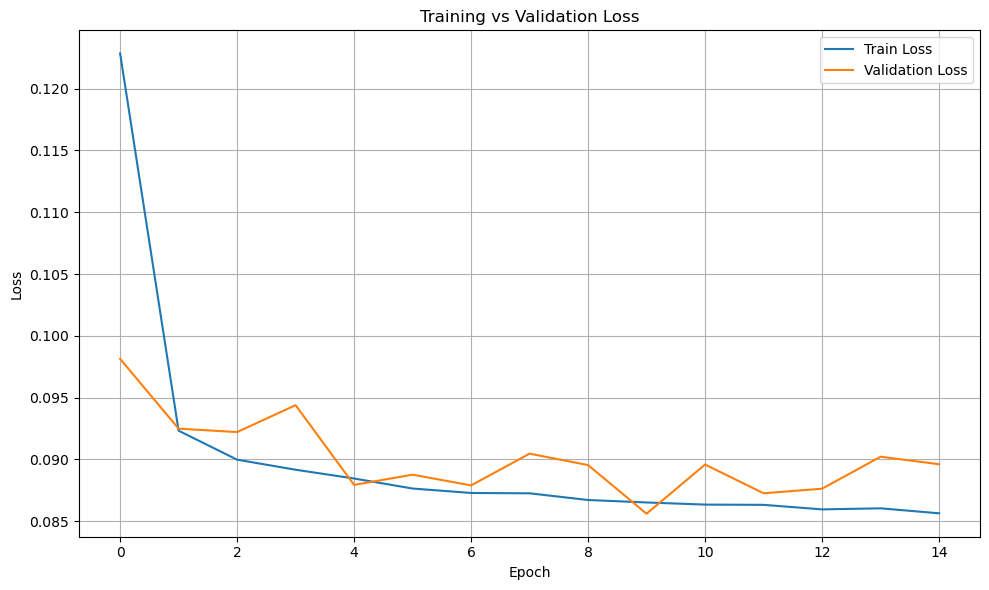

In [6]:
# === Step 6: Visualize Training and Validation Loss ===
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Evaluation Metrics on Test Set:
F1 Score (weighted): 0.9540
Precision: 0.9947
Recall: 0.5682
AUC-ROC: 0.8897
Confusion Matrix:
[[117224     37]
 [  5258   6919]]


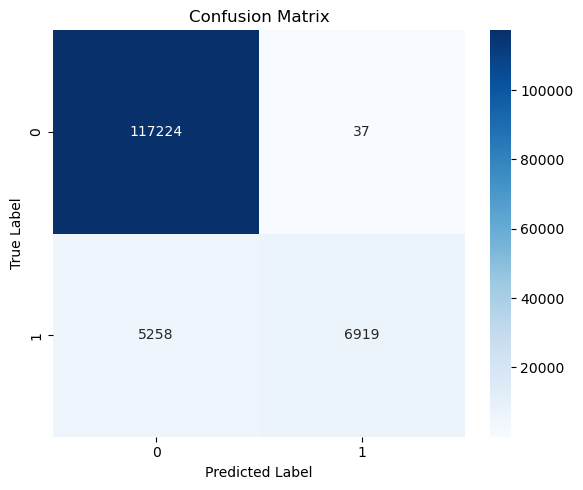

In [8]:
# === Step 7: Evaluate on Test Set with Comprehensive Metrics ===
from sklearn.metrics import roc_auc_score, classification_report

model.load_state_dict(best_model_state)
model.eval()
test_loader = DataLoader(test_dataset, batch_size=64)

y_pred, y_true = [], []
y_prob = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)

        y_true.extend(y_batch.numpy())
        y_pred.extend(preds.numpy())
        y_prob.extend(probs[:, 1].numpy())  # 预测为 class=1 的概率

# === Print Metrics ===
f1 = f1_score(y_true, y_pred, average="weighted")
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)
cm = confusion_matrix(y_true, y_pred)

print("Evaluation Metrics on Test Set:")
print(f"F1 Score (weighted): {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print("Confusion Matrix:")
print(cm)

# === Visualize Confusion Matrix ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()